# Unbalanced Cell Type Alignment

```{note}
This notebook is a sample of what our applications chapter will look like when we fully release it. We're working hard on compiling all of our results to share with you!
```

In this notebook, we'll look at what happens when we systematically downsample one of our domains in an alignment problem (simulating a situtation where we only have separately assayed data). In particular, we'll systematically downsample by cell type in a PBMC co-assayed dataset that contains RNA-seq (gene expression) and ATAC-seq (open chromatin) data. For now, we have provided our preprocessed version of this dataset in smaller files in the GitHub repository of this book, although we plan on additionally sharing our preprocessing steps once we have them in a publishable format.

```{tip}
If you have not yet configured a SCOT+ directory of some kind, see our installation instructions markdown. Once you complete those steps or set up your own virual environment, continue on here.

If you aren't sure what any of the parameters for setting up a Solver object mean, try our setup tutorial for getting used to using the tool.

If you are looking for more detail on what the parameters of the alignment do in practice, start by visiting our UGW, UCOOT, fused formulation tutorials. We will draw on all of these when examining AGW.

If you are unsure what some of the notation means throughout the rest of this document, try reading our optimal transport theory section to get more comfortable.

If you want to understand how to use AGW more generally, visit our AGW tutorial.
```

### Preprocessing

We can begin by loading in our data:

In [1]:
import pickle
import scanpy as sc
rna = pickle.load(open('./data/PBMC/rna_50pca_50topics.pkl', 'rb'))
atac = pickle.load(open('./data/PBMC/atac_50pca_50topics.pkl', 'rb'))
adata = sc.read_h5ad('./data/PBMC/adata.h5ad')

We can name our data and look at its shape:

In [2]:
import pandas as pd
atac.columns = ["Region {0}".format(i + 1) for i in range(50)]
rna.columns = ["Gene {0}".format(i + 1) for i in range(50)]
rna.shape, atac.shape

((2407, 50), (2407, 50))

We can additionally look at the cell types present:

In [3]:
ctypes = adata.obs['celltype']
ctypes = pd.Series(ctypes).loc[atac.index]
ctypes

CCAAGTTAGTAACCAC-1      CD14+ Monocytes
GTGCTTACAGTAATAG-1      CD14+ Monocytes
AGTCTTGCACAAAGAC-1    FCGR3A+ Monocytes
CTTTATGGTAAGCACC-1          CD4 T cells
CAATCGCCACTTCACT-1          CD4 T cells
                            ...        
CCGGTAGGTCGTTACT-1          CD4 T cells
CTAAATGTCTATTGTC-1          CD4 T cells
CCGCACACACTTCACT-1      CD14+ Monocytes
AATGCAACACCACAAC-1          CD4 T cells
CAAGGTTTCCCTGACT-1          CD4 T cells
Name: celltype, Length: 2407, dtype: category
Categories (7, object): ['B cells', 'CD4 T cells', 'CD8 T cells', 'CD14+ Monocytes', 'Dendritic cells', 'FCGR3A+ Monocytes', 'NK cells']

In [4]:
# attach celltype info to rna/atac data
rna = pd.concat((rna, ctypes), axis=1)
atac = pd.concat((atac, ctypes), axis=1)

In [5]:
from collections import Counter
Counter(rna['celltype'])
Counter(atac['celltype'])

Counter({'CD4 T cells': 1114,
         'CD14+ Monocytes': 648,
         'CD8 T cells': 207,
         'B cells': 201,
         'FCGR3A+ Monocytes': 109,
         'NK cells': 84,
         'Dendritic cells': 44})

From here, we can randomly sample fractions of each cell type to keep in the ATACseq domain:

In [6]:
import random

random.seed(5)
dfs = []
fracs = {}
for ctype, df in atac.groupby("celltype", observed=True):
    print(ctype)
    fracs[df["celltype"].iloc[0]] = 0.5 + 0.05*random.choice(range(0, 11, 1))
    dfs.append(df.sample(frac=fracs[df["celltype"].iloc[0]], random_state=10))
atac_mod = pd.concat((dfs), axis=0)
Counter(atac_mod['celltype'])

B cells
CD4 T cells
CD8 T cells
CD14+ Monocytes
Dendritic cells
FCGR3A+ Monocytes
NK cells


Counter({'CD4 T cells': 780,
         'CD14+ Monocytes': 648,
         'B cells': 191,
         'CD8 T cells': 155,
         'NK cells': 71,
         'FCGR3A+ Monocytes': 54,
         'Dendritic cells': 40})

In [7]:
# retrieving numeric matrices
atac_mtx = atac_mod.iloc[:, :-1]
rna_mtx = rna.iloc[:, :-1]

Note that we can easily view the manner in which we downsampled our data:

In [8]:
fracs

{'B cells': 0.95,
 'CD4 T cells': 0.7,
 'CD8 T cells': 0.75,
 'CD14+ Monocytes': 1.0,
 'Dendritic cells': 0.9,
 'FCGR3A+ Monocytes': 0.5,
 'NK cells': 0.8500000000000001}

### Alignment

Now, we can begin our usual AGW workflow:

In [70]:
from scotplus.solvers import SinkhornSolver
from sklearn.preprocessing import normalize
import matplotlib.pylab as plt
from sklearn.decomposition import PCA

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

As usual, we normalize our data:

In [71]:
rna_mtx=normalize(rna_mtx)
atac_mtx=normalize(atac_mtx)

And visualize it in two dimensions before alignment:

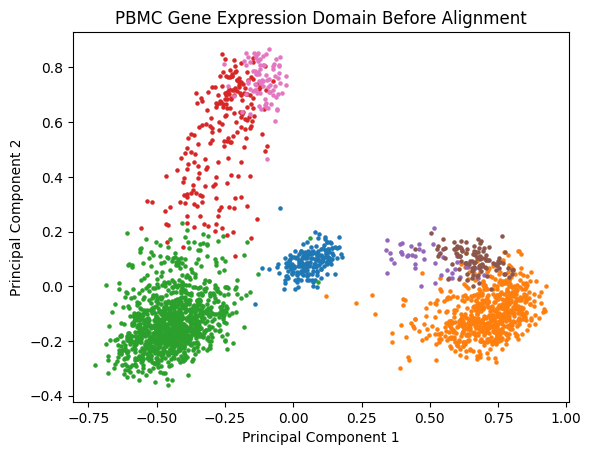

In [72]:
import numpy as np

label_array = np.array(rna['celltype'].to_list())

unique_labels = np.unique(label_array)
rna_pca = PCA(n_components=2)
rna_pca.fit(rna_mtx)
rna_2Dpca = rna_pca.transform(rna_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(rna_2Dpca[subset, 0], rna_2Dpca[subset, 1], s=5, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Gene Expression Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

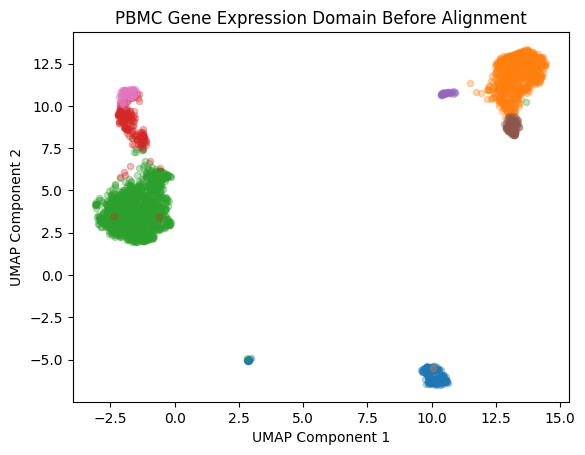

In [73]:
import umap

label_array = np.array(rna['celltype'].to_list())

unique_labels = np.unique(label_array)
rna_umap=umap.UMAP(n_components=2, transform_seed=10)
rna_umap.fit(rna_mtx)
rna_2Dumap=rna_umap.transform(rna_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(rna_2Dumap[subset, 0], rna_2Dumap[subset, 1], s=20, alpha=0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('PBMC Gene Expression Domain Before Alignment')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

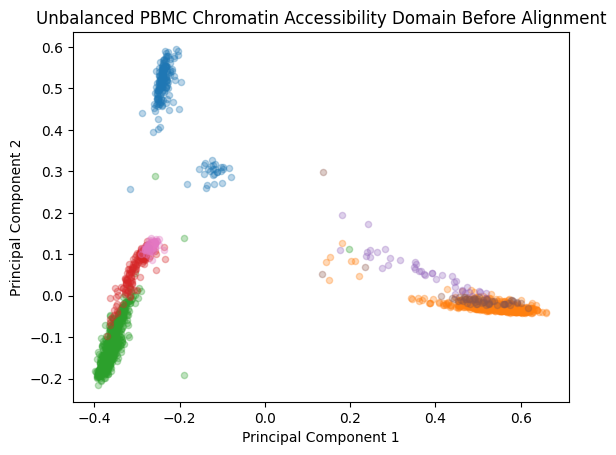

In [74]:
import numpy as np

label_array = np.array(atac_mod['celltype'].to_list())

unique_labels = np.unique(label_array)
atac_pca=PCA(n_components=2)
atac_2Dpca=atac_pca.fit_transform(atac_mtx)
plt.figure()

for label in unique_labels:
    subset = (label_array == label)
    plt.scatter(atac_2Dpca[subset, 0], atac_2Dpca[subset, 1], s=20, alpha=0.3, label=label)

# plt.legend(loc='best', shadow=False)
plt.title('Unbalanced PBMC Chromatin Accessibility Domain Before Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

We can now attempt an alignment:

In [17]:
from scotplus.utils.alignment import compute_graph_distances
D_rna = compute_graph_distances(rna_mtx, n_neighbors=110, mode='connectivity')
D_atac = compute_graph_distances(atac_mtx.astype('float32'), n_neighbors=110, mode='connectivity')

In [38]:
scot = SinkhornSolver(tol_uot=1e-6, nits_uot=500, nits_bcd=10)
pi_samp,_,pi_feat = scot.ugw(D_rna, D_atac, rho = (0.05, 0.05), eps = 5e-3, verbose = False)

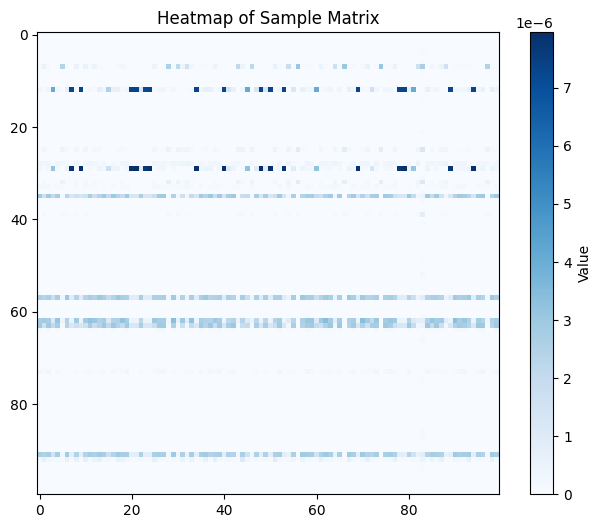

In [39]:
# plot a corner of the heatmap to get a sense for density
plt.figure(figsize=(8, 6))
plt.imshow(pi_samp[0:100,0:100], cmap='Blues', interpolation='nearest')
plt.colorbar(label='Value')
plt.title('Heatmap of Sample Matrix')
plt.show()

Now, we can finally compute our alignment:

In [40]:
from scotplus.utils.alignment import get_barycentre
aligned_atac = get_barycentre(rna_mtx, np.transpose(pi_samp))
rna_mtx.shape, aligned_atac.shape

((2407, 50), torch.Size([1939, 50]))

### Evaluation

We can begin by visualizing the aligned data on its own, as well as in conjunction with the original RNAseq data:

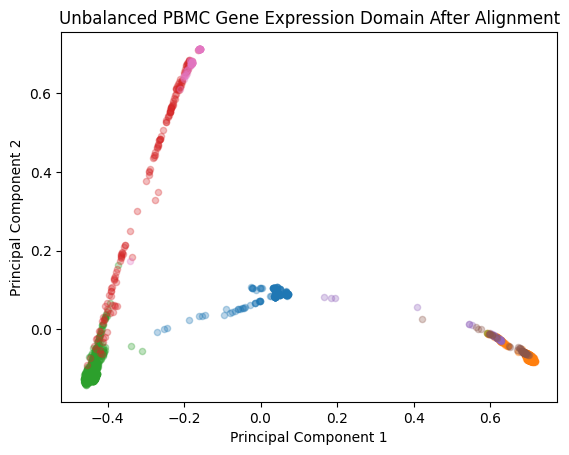

In [44]:
Xrna_integrated=rna_mtx
Yatac_subsamp_integrated=aligned_atac
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

x_labels = np.array(rna['celltype'])
concat_labels = np.concatenate((x_labels,label_array),axis=0)
concat_pc = np.concatenate((Xrna_integrated_pc,Yatac_subsamp_integrated_pc), axis=0)
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Yatac_subsamp_integrated_pc[mask, 0], Yatac_subsamp_integrated_pc[mask, 1], s=20, alpha=0.3, label = label)
    
    
plt.title('Unbalanced PBMC Gene Expression Domain After Alignment')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


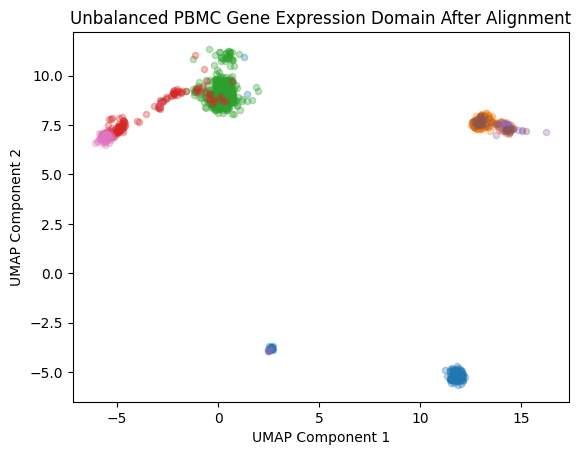

In [45]:
Xrna_integrated=rna_mtx
Yatac_subsamp_integrated=aligned_atac
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_umap=rna_umap.transform(concatenated)
Xrna_integrated_umap=concatenated_umap[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_umap=concatenated_umap[Xrna_integrated.shape[0]:,:]

x_labels = np.array(rna['celltype'])
concat_labels = np.concatenate((x_labels,label_array),axis=0)
concat_pc = np.concatenate((Xrna_integrated_umap,Yatac_subsamp_integrated_umap), axis=0)
for label in unique_labels:
    mask = (label_array == label)
    plt.scatter(Yatac_subsamp_integrated_umap[mask, 0], Yatac_subsamp_integrated_umap[mask, 1], s=20, alpha=0.3, label = label)
    
    
plt.title('Unbalanced PBMC Gene Expression Domain After Alignment')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

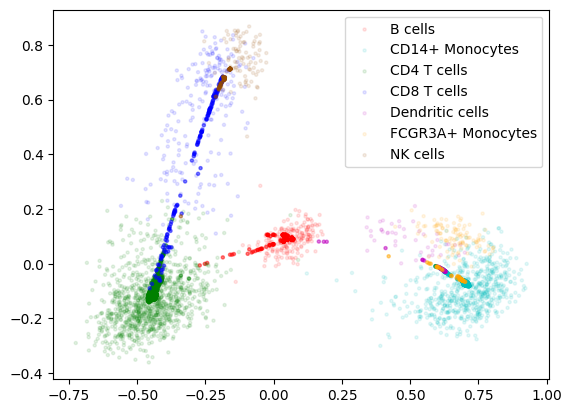

In [79]:
Xrna_integrated=rna_mtx
Yatac_subsamp_integrated=aligned_atac
concatenated=np.concatenate((Xrna_integrated,Yatac_subsamp_integrated), axis=0)

concatenated_pc=rna_pca.transform(concatenated)
Xrna_integrated_pc=concatenated_pc[0:Xrna_integrated.shape[0],:]
Yatac_subsamp_integrated_pc=concatenated_pc[Xrna_integrated.shape[0]:,:]

x_labels = np.array(rna['celltype'])
alphas = (np.hstack((np.ones_like(x_labels, dtype=int)/10, np.ones_like(label_array, dtype=int)/2)))

for (label, color) in zip(unique_labels, ['r', 'c', 'g', 'b', 'm', '#ffa500', '#964b00']):
    mask = (np.hstack((x_labels, label_array)) == label)
    plt.scatter(np.vstack((Xrna_integrated_pc, Yatac_subsamp_integrated_pc))[mask, 0], np.vstack((Xrna_integrated_pc, Yatac_subsamp_integrated_pc))[mask, 1], s=5, label = label, c=color, alpha=alphas[mask])
plt.legend(loc='best', shadow=False)
plt.show()


We can evaluate our alignment with label transfer accuracy, which determines how well a classifier extends from the original domain to the new domain:

In [80]:
from sklearn.neighbors import KNeighborsClassifier
def transfer_accuracy(domain1, domain2, type1, type2,n):
	"""
	Metric from UnionCom: "Label Transfer Accuracy"
	"""
	knn = KNeighborsClassifier(n_neighbors=n)
	knn.fit(domain2, type2)
	type1_predict = knn.predict(domain1)
	count = 0
	for label1, label2 in zip(type1_predict, type1):
		if label1 == label2:
			count += 1
	return count / len(type1)

In [81]:
transfer_accuracy(Xrna_integrated,Yatac_subsamp_integrated,rna['celltype'],atac_mod['celltype'],5)

0.896551724137931